# Stochastic Ablation Notebook 2
## Conditional circuit branches

This follw-up notebook digs deeper determining conditional probabilities for two heads succeeding or failing together. This is used to map out circuits as branching substructures.

[Run this notebook on Google Colab](https://colab.research.google.com/github/thartlep/stochastic-ablation/blob/main/notebook2.ipynb)

### Some settings to adjust:

In [ ]:
# Nothing yet

### Import Python modules and load data from first notebook:

In [44]:
# Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from collections import defaultdict
import networkx as nx

# Load data
file_path = "stochastic_ablation__monte_carlo_results.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)
results__many_ablated = data["results__many_ablated"]
results__few_ablated = data["results__few_ablated"]
model_name = data["model_name"]
n_layers = data["n_layers"]
n_heads = data["n_heads"]
head_indices = [(l,h) for l in range(n_layers) for h in range(n_heads)]
n_heads_total = len(head_indices)

### Compute probabilities (individual and conditional):

In [ ]:
def compute_individual_success_probs(results, num_heads):
    count_present = np.zeros(num_heads)
    count_present_success = np.zeros(num_heads)

    for mask, success, _ in tqdm(results):
        present = np.where(mask == 1)[0]
        count_present[present] += 1
        if success:
            count_present_success[present] += 1

    prob_success = np.divide(
        count_present_success,
        count_present,
        out=np.zeros_like(count_present_success),
        where=count_present != 0
    )

    return prob_success

def compute_conditional_probabilities(results_A, results_B, num_heads):
    """
    Computes the probability of success and failure given that both head i and head j are present.
    
    Parameters:
    - results_A: list of (mask, success, prompt_idx) where success
    may be True or False but we use only success cases 
    - results_B: list of (mask, success, prompt_idx) where success
    may be True or False but we use only failure cases
    - num_heads: total number of heads (layers * heads_per_layer)
    
    Returns:
    - cond_probs_success: dict mapping (i,j) -> P(success | i,j present)
    - cond_probs_failure: dict mapping (i,j) -> P(failure | i,j present)
    """
    count_joint_present_A = np.zeros((num_heads, num_heads))
    count_joint_present_B = np.zeros((num_heads, num_heads))
    count_joint_present_A_success = np.zeros((num_heads, num_heads))
    count_joint_present_B_failure = np.zeros((num_heads, num_heads))

    # Success runs
    for mask, success, _ in tqdm(results_A):
        if success:
            present_heads = np.where(mask == 1)[0]
            for i in present_heads:
                for j in present_heads:
                    count_joint_present_A[i, j] += 1
                    count_joint_present_A_success[i, j] += 1

    # Failure runs
    for mask, success, _ in tqdm(results_B):
        if not success:
            present_heads = np.where(mask == 1)[0]
            for i in present_heads:
                for j in present_heads:
                    count_joint_present_A[i, j] += 1
                    count_joint_present_B_failure[i, j] += 1

    # Compute conditional probabilities
    cond_probs_success = np.divide(
        count_joint_present_A_success,
        count_joint_present_A,
        out=np.zeros_like(count_joint_present_A_success),
        where=count_joint_present_A != 0
    )

    cond_probs_failure = np.divide(
        count_joint_present_B_failure,
        count_joint_present_B,
        out=np.zeros_like(count_joint_present_B_failure),
        where=count_joint_present_B != 0
    )

    return cond_probs_success, cond_probs_failure

def compute_delta_matrix(cond_probs_success, prob_success_indiv):
    num_heads = len(prob_success_indiv)
    delta_matrix = np.zeros((num_heads, num_heads))

    for i in range(num_heads):
        for j in range(num_heads):
            expected = prob_success_indiv[i] * prob_success_indiv[j]
            delta_matrix[i, j] = cond_probs_success[i, j] - expected

    return delta_matrix

# Run individual analysis
indiv_prob_success = compute_individual_success_probs(
    results__many_ablated + results__few_ablated,
    n_heads_total
)

# Run conditional analysis
cond_probs_success, cond_probs_failure = compute_conditional_probabilities(
    results__many_ablated,
    results__few_ablated,
    n_heads_total
)

# Compute delta matrix
delta_matrix = compute_delta_matrix(cond_probs_success, indiv_prob_success)

100%|██████████| 570000/570000 [05:38<00:00, 1684.37it/s]


### Build and plot head graph:

delta_matrix.shape=(144, 144)
np.max(delta_matrix)=0.010362383363811456, np.min(delta_matrix)=-0.4176780419424965


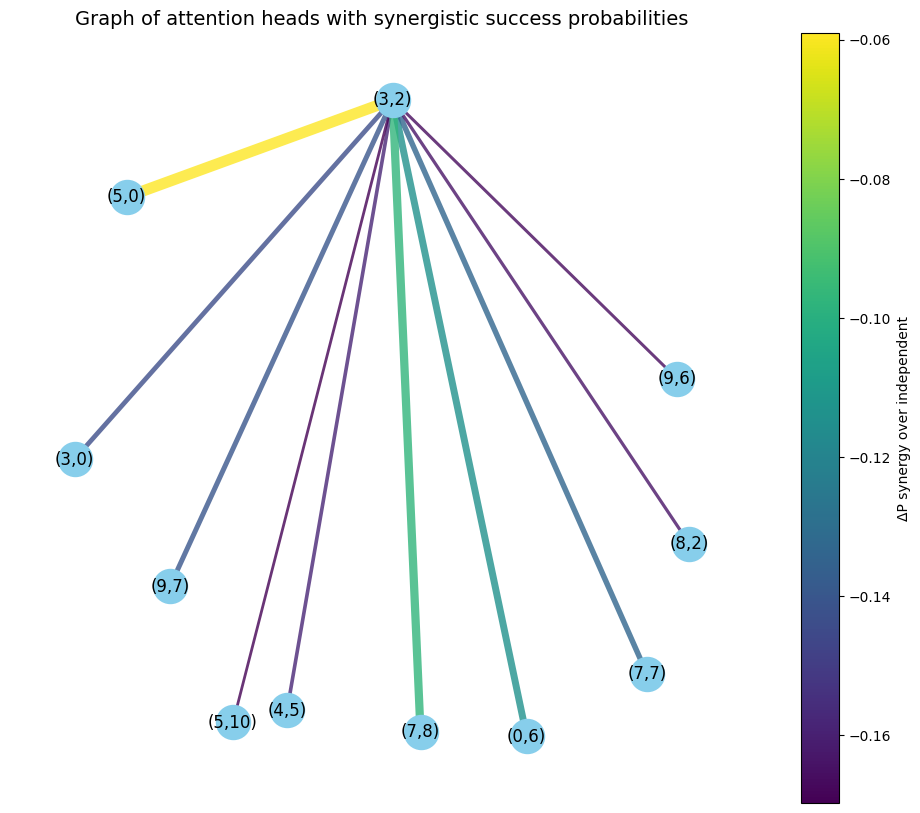

In [77]:
def build_head_graph(delta_matrix, threshold=0.05):
    G = nx.Graph()
    num_heads = delta_matrix.shape[0]

    # Add nodes
    G.add_nodes_from(range(num_heads))

    # Add edges where the synergy is significant
    for i in range(num_heads):
        for j in range(i+1, num_heads):  # only upper triangle, undirected graph
            if delta_matrix[i, j] > threshold:
                G.add_edge(i, j, weight=delta_matrix[i, j])

    return G

def plot_head_graph(G):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    nx.draw(G, pos, node_color='skyblue', node_size=600, with_labels=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=[5*w for w in weights], alpha=0.6)
    plt.title("Graph of attention heads with synergistic success probabilities")
    plt.show()

def plot_head_graph_colored(G, cmap=plt.cm.viridis):
    # Only plot nodes that are connected by edges
    connected_nodes = set()
    for u, v in G.edges():
        connected_nodes.add(u)
        connected_nodes.add(v)
    H = G.subgraph(connected_nodes)

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(H, k=0.4, iterations=50, seed=42)

    edges = H.edges()
    weights = np.array([H[u][v]['weight'] for u, v in edges])

    if len(weights) > 0:
        norm = plt.Normalize(weights.min(), weights.max())
        edge_colors = cmap(norm(weights))
        edge_widths = 2 + 6 * norm(weights)
    else:
        edge_colors = []
        edge_widths = []

    # Draw nodes and labels
    nx.draw_networkx_nodes(H, pos, node_color='skyblue', node_size=600)
    nx.draw_networkx_labels(H, pos)

    # Draw edges with color & width
    nx.draw_networkx_edges(
        H, pos, edgelist=edges,
        edge_color=edge_colors, width=edge_widths, alpha=0.8
    )

    # Colorbar
    if len(weights) > 0:
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label('ΔP synergy over independent')

    plt.title("Graph of attention heads with synergistic success probabilities", fontsize=14)
    plt.axis('off')
    plt.show()


print(f'{delta_matrix.shape=}')
print(f'{np.max(delta_matrix)=}, {np.min(delta_matrix)=}')

# Build graph
G = build_head_graph(delta_matrix, threshold=-0.17)

# Relabel heads
mapping = { idx: f"({layer},{head})" for idx, (layer, head) in enumerate(head_indices) }
G = nx.relabel_nodes(G, mapping)

# Plot graph
# plot_head_graph(G)
plot_head_graph_colored(G)